## Compare compressed vs. raw results

In this notebook, we want to compare mutation status classification results with varying numbers of PCA components as predictors against results with raw features (CpG beta values for methylation data, standardized per-gene expression values for RNA-seq data).

Notebook parameters:
* SIG_ALPHA (float): significance cutoff after FDR correction

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directories
results_dir = Path(cfg.results_dirs['mutation'], 'methylation_results_new', 'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

# if True, save figures to ./images directory
SAVE_FIGS = True

In [3]:
# load raw data
raw_results_df = au.load_stratified_prediction_results(results_dir, 'gene')

print(raw_results_df.shape)
print(raw_results_df.seed.unique())
print(raw_results_df.training_data.unique())
raw_results_df.head()

(12096, 9)
[42  1]
['me_450k' 'expression' 'me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,1.00000,1.00000,MAP3K1,me_450k,signal,42,train,0,gene
1,0.55110,0.17961,MAP3K1,me_450k,signal,42,test,0,gene
2,0.63071,0.23495,MAP3K1,me_450k,signal,42,cv,0,gene
3,1.00000,1.00000,MAP3K1,me_450k,signal,42,train,1,gene
4,0.60851,0.20028,MAP3K1,me_450k,signal,42,test,1,gene


In [4]:
# load compressed data
compressed_results_df = au.load_compressed_prediction_results(results_dir, 'gene')

print(compressed_results_df.shape)
print(compressed_results_df.seed.unique())
print(compressed_results_df.n_dims.unique())
print(compressed_results_df.training_data.unique())
compressed_results_df.head()

(36288, 10)
[ 1 42]
[1000  100 5000]
['expression' 'me_27k' 'me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,0.55777,0.118030,MAP3K1,expression,shuffled,1,train,0,1000,gene
1,0.55126,0.088517,MAP3K1,expression,shuffled,1,test,0,1000,gene
2,0.52266,0.083458,MAP3K1,expression,shuffled,1,cv,0,1000,gene
3,0.91931,0.471150,MAP3K1,expression,shuffled,1,train,1,1000,gene
4,0.54170,0.114300,MAP3K1,expression,shuffled,1,test,1,1000,gene


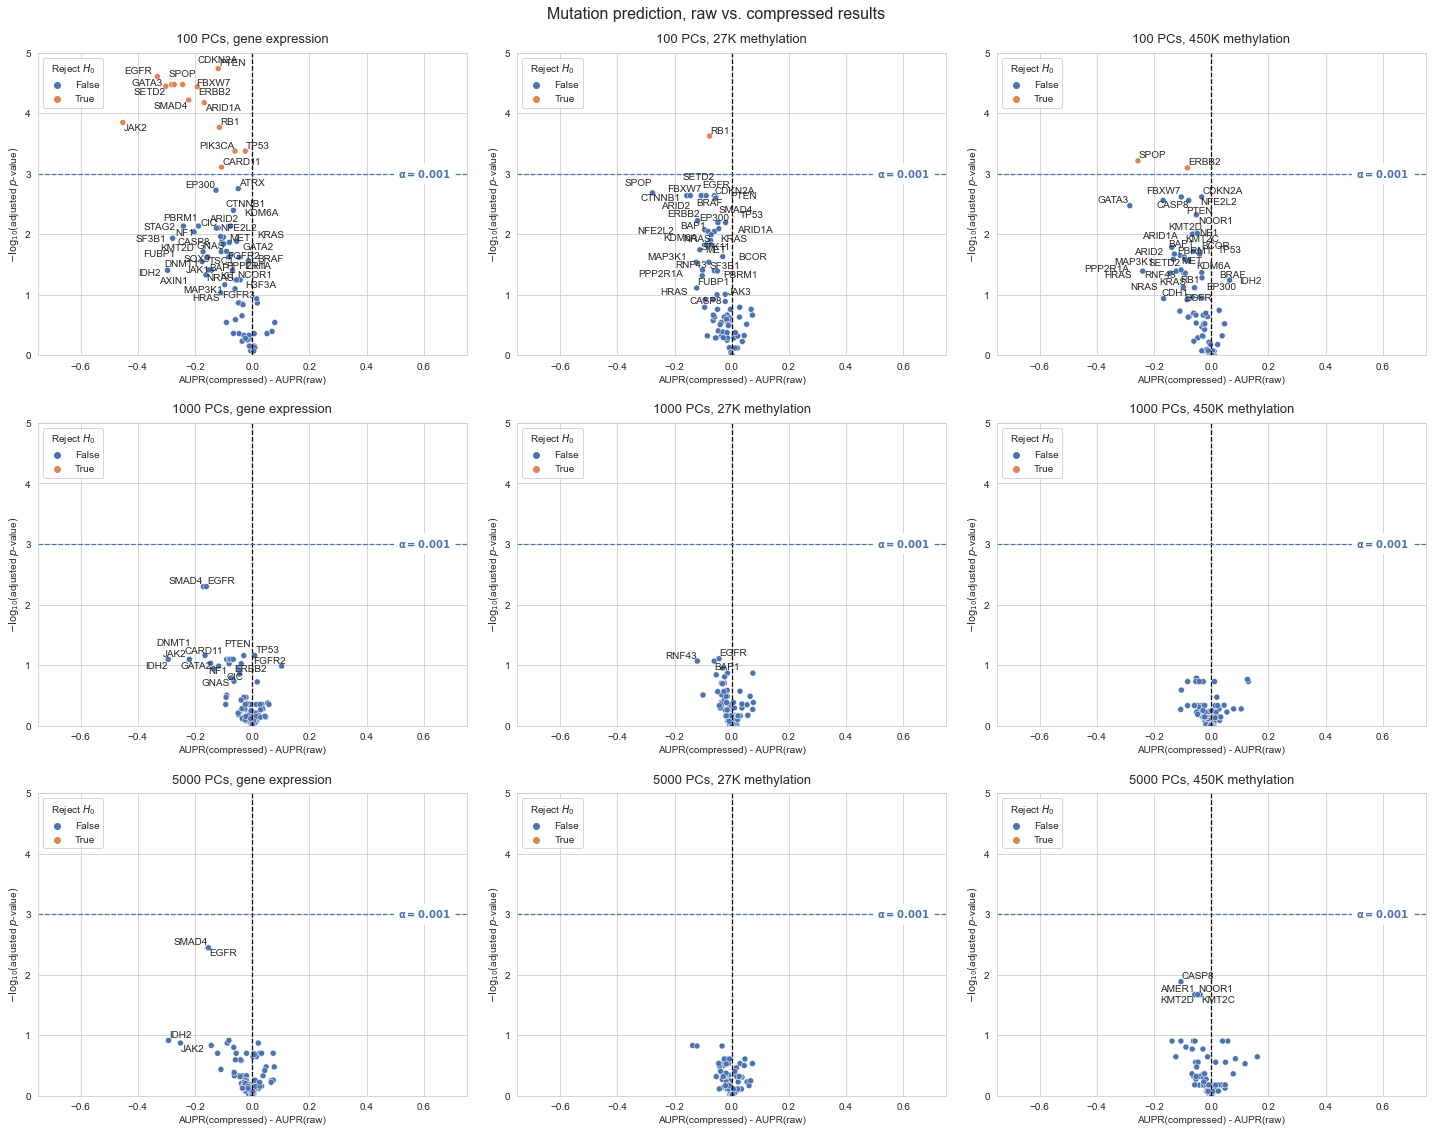

In [5]:
def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        if point['y'] > 1.0 or abs(point['x']) > 0.2:
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# plot comparisons for all pairwise combinations of training datasets,
# within each choice of compression dimension
import itertools as it

sns.set({'figure.figsize': (20, 16)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(3, 3)

raw_results_df.sort_values(by=['training_data'], inplace=True)
compressed_results_df.sort_values(by=['n_dims', 'training_data'], inplace=True)
for row_ix, n_dims in enumerate(compressed_results_df.n_dims.unique()):
    for col_ix, train_data in enumerate(compressed_results_df.training_data.unique()):
        raw_data_df = raw_results_df[
            (raw_results_df.training_data == train_data)
        ].copy()
        raw_data_df.sort_values(by=['seed', 'fold'], inplace=True)
        compressed_data_df = compressed_results_df[
            (compressed_results_df.n_dims == n_dims) &
            (compressed_results_df.training_data == train_data)
        ].copy()
        compressed_data_df.sort_values(by=['seed', 'fold'], inplace=True)
        compare_df = au.compare_results(raw_data_df,
                                        compressed_data_df,
                                        identifier='identifier',
                                        metric='aupr',
                                        correction=True,
                                        correction_method='fdr_bh',
                                        correction_alpha=SIG_ALPHA,
                                        verbose=False)
        compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
        compare_df['nlog10_p'] = -np.log10(compare_df.corr_pval)
        
        ax = axarr[row_ix, col_ix]
        sns.scatterplot(data=compare_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                        hue_order=[False, True], ax=ax)
        # add vertical line at 0
        ax.axvline(x=0, linestyle='--', color='black', linewidth=1.25)
        # add horizontal line at statistical significance threshold
        l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25)
        # label horizontal line with significance threshold
        # (matplotlib makes this fairly difficult, sadly)
        ax.text(0.6, -np.log10(SIG_ALPHA)+0.01,
                r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
                va='center', ha='center', color=l.get_color(),
                backgroundcolor=ax.get_facecolor())
        # NOTE compare_results function takes df2 - df1, so we have to invert them here
        ax.set_xlabel('AUPR(compressed) - AUPR(raw)')
        ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
        ax.set_xlim((-0.75, 0.75))
        ax.set_ylim((0, 5))
        ax.legend(title=r'Reject $H_0$', loc='upper left')
        train_names = {
            'expression': 'gene expression',
            'me_27k': '27K methylation',
            'me_450k': '450K methylation',
        }
        ax.set_title(r'{} PCs, {}'.format(n_dims, train_names[train_data]),
                     size=13, pad=10)
        

        # label genes and adjust text to not overlap
        # automatic alignment isn't perfect, can align by hand in inkscape if necessary
        text_labels = label_points(compare_df['delta_mean'],
                                   compare_df['nlog10_p'],
                                   compare_df.gene,
                                   compare_df.reject_null,
                                   ax)
        adjust_text(text_labels,
                    ax=ax, 
                    expand_text=(1., 1.),
                    lim=5)

plt.suptitle('Mutation prediction, raw vs. compressed results', size=16)
plt.tight_layout(w_pad=2, h_pad=2)
plt.subplots_adjust(top=0.94)

In [6]:
raw_compare_df = pd.DataFrame()
for train_data in raw_results_df.training_data.unique():
    raw_train_df = (
        raw_results_df[raw_results_df.training_data == train_data]
            .drop(columns=['training_data'])
    )
    raw_train_df.sort_values(by=['seed', 'fold'], inplace=True)
    raw_train_compare_df = au.compare_control_ind(raw_train_df,
                                                  identifier='identifier',
                                                  metric='aupr',
                                                  verbose=False)
    raw_train_compare_df['training_data'] = train_data
    raw_train_compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
    raw_compare_df = pd.concat((raw_compare_df, raw_train_compare_df))
raw_compare_df.sort_values(by=['training_data'], inplace=True)
raw_compare_df.head(5)

,gene,seed,fold,delta_aupr,training_data
0,ABL1,1,0,-0.117860,expression
443,MET,1,3,0.175260,expression
444,MET,42,0,0.285317,expression
445,MET,42,1,0.151318,expression
446,MET,42,2,0.151766,expression


In [7]:
print(compressed_results_df.shape)
cmp_compare_df = pd.DataFrame()
for train_data in compressed_results_df.training_data.unique():
    for n_dims in compressed_results_df.n_dims.unique():
        cmp_train_df = (
            compressed_results_df[(compressed_results_df.training_data == train_data) &
                                  (compressed_results_df.n_dims == n_dims)]
                .drop(columns=['training_data'])
        )
        cmp_train_df.sort_values(by=['seed', 'fold'], inplace=True)
        cmp_train_compare_df = au.compare_control_ind(cmp_train_df,
                                                      identifier='identifier',
                                                      metric='aupr',
                                                      verbose=True)
        cmp_train_compare_df['training_data'] = train_data
        cmp_train_compare_df['n_dims'] = n_dims
        cmp_train_compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
        cmp_compare_df = pd.concat((cmp_compare_df, cmp_train_compare_df))
print(cmp_compare_df.shape)
cmp_compare_df.sort_values(by=['training_data', 'n_dims'], inplace=True)
cmp_compare_df.head(5)

(36288, 10)
(6048, 6)


,gene,seed,fold,delta_aupr,training_data,n_dims
0,ABL1,1,0,-0.982456,expression,100
1,ABL1,1,1,-0.001002,expression,100
2,ABL1,1,2,-0.011267,expression,100
3,ABL1,1,3,-0.053850,expression,100
4,ABL1,42,0,-0.033406,expression,100


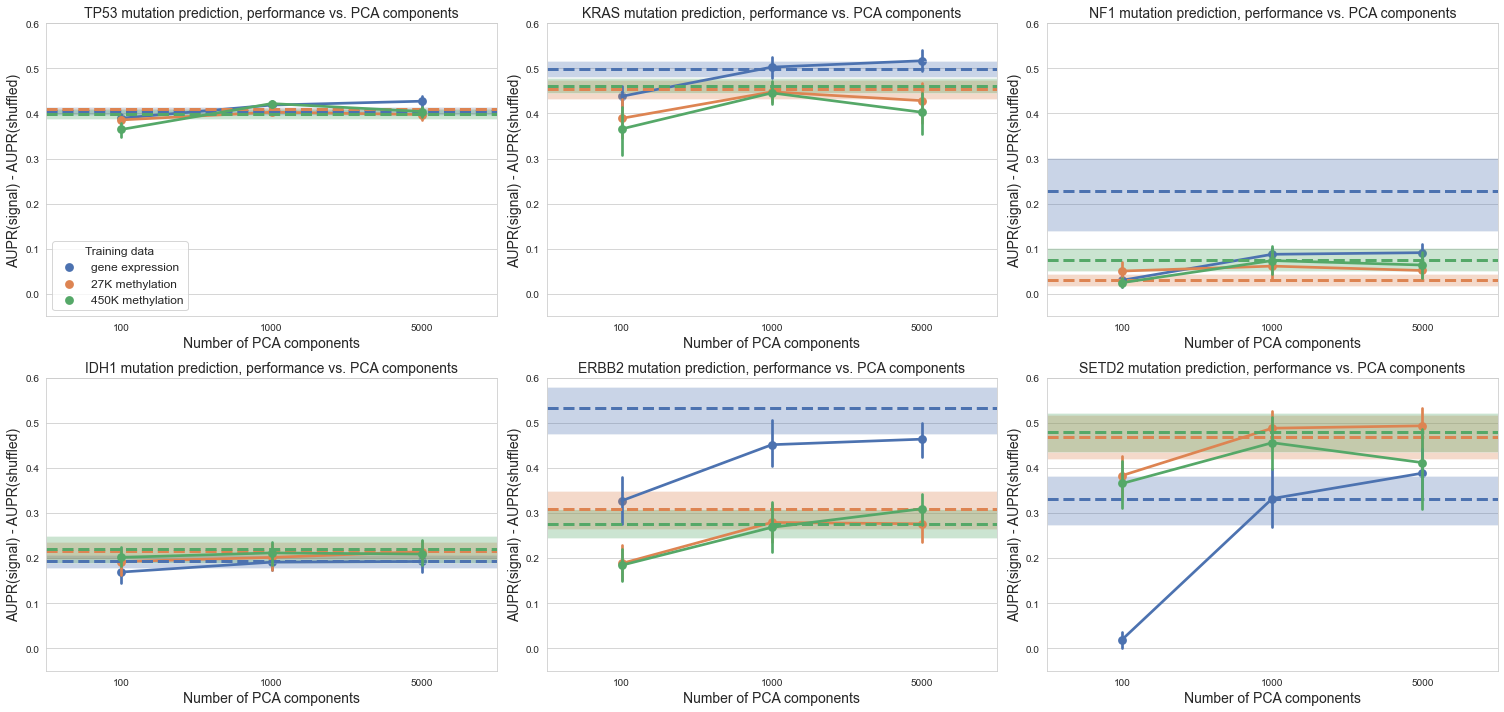

In [8]:
# look at some specific genes, we can do this using a line plot of 
# performance over increasing number of PCs
# dotted line = performance with raw features (genes/probes)
genes = ['TP53', 'KRAS', 'NF1', 'IDH1', 'ERBB2', 'SETD2']
sns.set({'figure.figsize': (21, 10)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 3)

for ix, gene in enumerate(genes):
    ax = axarr[ix // 3, ix % 3]
    cmp_gene_df = cmp_compare_df[cmp_compare_df.gene == gene].copy()
    cmp_gene_df.training_data.replace(to_replace=train_names, inplace=True)
    g = sns.pointplot(data=cmp_gene_df, x='n_dims', y='delta_aupr', hue='training_data', ax=ax, legend=False)
    if ix != 0:
        ax.get_legend().remove()
    else:
        ax.legend(title='Training data', fontsize=12, title_fontsize=12,
                  loc='lower left')
        
    for color_ix, train_data in enumerate(raw_compare_df.training_data.unique()):
        raw_vals = raw_compare_df[
            (raw_compare_df.gene == gene) &
            (raw_compare_df.training_data == train_data)].delta_aupr.values
        
        # get mean and plot as dotted line
        raw_mean = np.mean(raw_vals)
        ax.axhline(y=raw_mean, linestyle='--', linewidth=3, color=sns.color_palette()[color_ix])
        
        # get bootstrapped 95% CI, using seaborn method
        # plot as transparent shaded region
        raw_ci = sns.utils.ci(
            sns.algorithms.bootstrap(raw_vals,
                                     func=np.mean,
                                     n_boot=1000,
                                     units=None,
                                     seed=cfg.default_seed)
        )
        ax.axhspan(raw_ci[0], raw_ci[1], facecolor=sns.color_palette()[color_ix], alpha=0.3)
        
    ax.set_title('{} mutation prediction, performance vs. PCA components'.format(gene), size=14)
    ax.set_xlabel('Number of PCA components', size=14)
    ax.set_ylabel('AUPR(signal) - AUPR(shuffled)', size=14)
    raw_gene_df = raw_compare_df[raw_compare_df.gene == gene]
    ax.set_ylim(-0.05, 0.6)
    
plt.tight_layout()

if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['mutation'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'methylation_genes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_genes.png',
                dpi=300, bbox_inches='tight')

In [9]:
raw_compare_df = au.compare_all_data_types(raw_results_df, SIG_ALPHA, filter_genes=False)
cmp_compare_df = au.compare_data_types_and_dims(compressed_results_df, SIG_ALPHA, filter_genes=False)

raw_compare_df['n_dims'] = 'raw'
compare_df = (
    pd.concat((raw_compare_df, cmp_compare_df))
      .sort_values(by=['training_data', 'n_dims'])
)
compare_df.training_data.replace(to_replace=train_names, inplace=True)
compare_df.head()

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p,n_dims
0,ABL1,-0.111031,4.081740e-01,4.511397e-01,False,gene expression,0.345689,100
1,ALK,0.035240,1.941782e-01,2.363909e-01,False,gene expression,0.626369,100
2,AMER1,0.025113,6.192796e-02,8.669914e-02,False,gene expression,1.061985,100
3,APC,0.571295,1.357567e-08,2.280713e-07,True,gene expression,6.641929,100
4,ARID1A,0.258595,8.804964e-07,5.282978e-06,True,gene expression,5.277121,100


(55,)
['APC' 'ARID1A' 'ATRX' 'AXIN1' 'BAP1' 'BRAF' 'CASP8' 'CDH1' 'CDKN2A' 'CIC'
 'CTNNB1' 'EGFR' 'ERBB2' 'FBXW7' 'FGFR3' 'FUBP1' 'HRAS' 'IDH1' 'KDM6A'
 'KMT2C' 'KMT2D' 'KRAS' 'NFE2L2' 'NOTCH1' 'NRAS' 'PBRM1' 'PIK3CA'
 'PPP2R1A' 'PTEN' 'RB1' 'SMAD4' 'SPOP' 'STK11' 'TP53' 'TSC1' 'GATA3' 'NF1'
 'RNF43' 'SETD2' 'SF3B1' 'STAG2' 'EP300' 'GNAS' 'JAK1' 'MAP3K1' 'ARID2'
 'JAK2' 'NF2' 'BCOR' 'MED12' 'SMARCA4' 'H3F3A' 'MET' 'NCOR1' 'AMER1']


(-0.2, 0.640595)

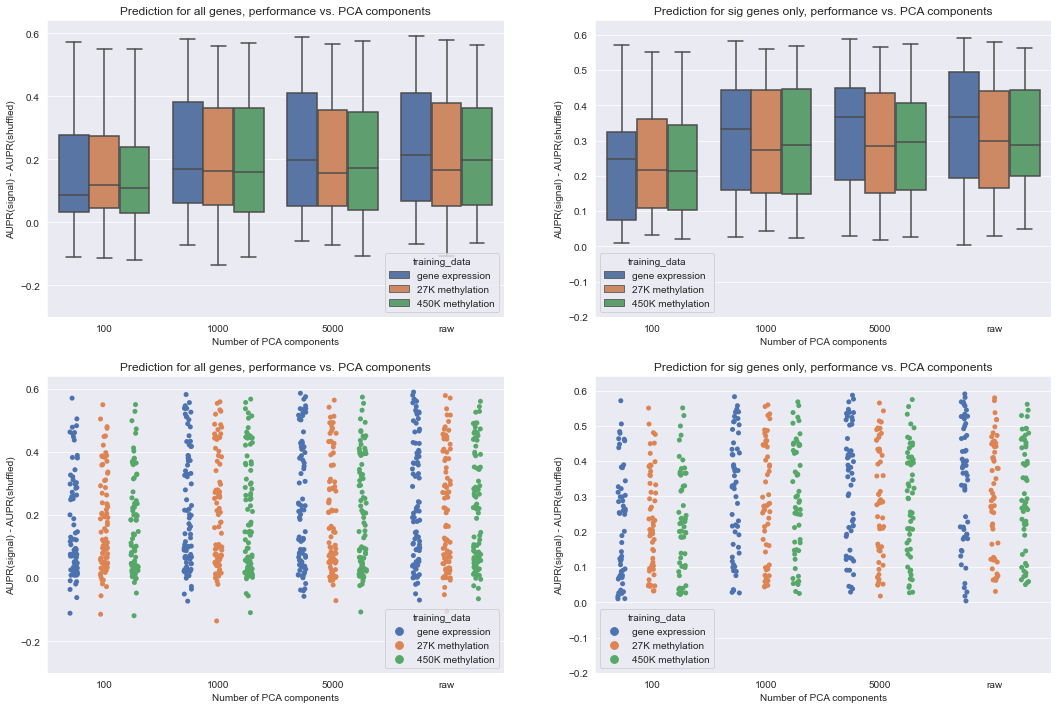

In [10]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr[0, 0]
sns.boxplot(data=compare_df, x='n_dims', y='delta_mean', hue='training_data', ax=ax)
ax.set_title('Prediction for all genes, performance vs. PCA components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.3, max(compare_df.delta_mean + 0.05))


# plot mean performance for genes that are significant for at least one data type
ax = axarr[0, 1]
gene_list = compare_df[compare_df.reject_null == True].gene.unique()
print(gene_list.shape)
print(gene_list)
sns.boxplot(data=compare_df[compare_df.gene.isin(gene_list)], x='n_dims', y='delta_mean', hue='training_data', ax=ax)
ax.set_title('Prediction for sig genes only, performance vs. PCA components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(compare_df.delta_mean + 0.05))

ax = axarr[1, 0]
sns.stripplot(data=compare_df, x='n_dims', y='delta_mean', hue='training_data', dodge=True, ax=ax)
ax.set_title('Prediction for all genes, performance vs. PCA components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.3, max(compare_df.delta_mean + 0.05))

ax = axarr[1, 1]
sns.stripplot(data=compare_df[compare_df.gene.isin(gene_list)], x='n_dims', y='delta_mean',
              hue='training_data', dodge=True, ax=ax)
ax.set_title('Prediction for sig genes only, performance vs. PCA components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(compare_df.delta_mean + 0.05))

(55,)
['APC' 'ARID1A' 'ATRX' 'AXIN1' 'BAP1' 'BRAF' 'CASP8' 'CDH1' 'CDKN2A' 'CIC'
 'CTNNB1' 'EGFR' 'ERBB2' 'FBXW7' 'FGFR3' 'FUBP1' 'HRAS' 'IDH1' 'KDM6A'
 'KMT2C' 'KMT2D' 'KRAS' 'NFE2L2' 'NOTCH1' 'NRAS' 'PBRM1' 'PIK3CA'
 'PPP2R1A' 'PTEN' 'RB1' 'SMAD4' 'SPOP' 'STK11' 'TP53' 'TSC1' 'GATA3' 'NF1'
 'RNF43' 'SETD2' 'SF3B1' 'STAG2' 'EP300' 'GNAS' 'JAK1' 'MAP3K1' 'ARID2'
 'JAK2' 'NF2' 'BCOR' 'MED12' 'SMARCA4' 'H3F3A' 'MET' 'NCOR1' 'AMER1']


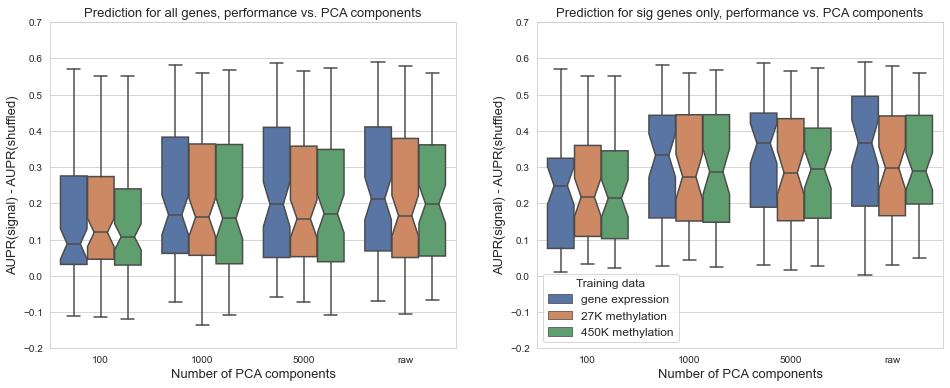

In [11]:
# same plot but only the first row (box plots)
sns.set({'figure.figsize': (16, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr[0]
sns.boxplot(data=compare_df, x='n_dims', y='delta_mean', hue='training_data', notch=True, ax=ax)
ax.get_legend().remove()
ax.set_title('Prediction for all genes, performance vs. PCA components', size=13)
ax.set_xlabel('Number of PCA components', size=13)
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)', size=13)
ax.set_ylim(-0.2, 0.7)


# plot mean performance for genes that are significant for at least one data type
ax = axarr[1]
gene_list = compare_df[compare_df.reject_null == True].gene.unique()
print(gene_list.shape)
print(gene_list)
sns.boxplot(data=compare_df[compare_df.gene.isin(gene_list)], x='n_dims', y='delta_mean',
            hue='training_data', notch=True, ax=ax)
ax.legend(title='Training data', fontsize=12, title_fontsize=12,
          loc='lower left')
ax.set_title('Prediction for sig genes only, performance vs. PCA components', size=13)
ax.set_xlabel('Number of PCA components', size=13)
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)', size=13)
ax.set_ylim(-0.2, 0.7)

if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['mutation'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'methylation_compress_boxes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_compress_boxes.png',
                dpi=300, bbox_inches='tight')